# Build a CTM

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
from collections import defaultdict

# import gradio as gr
import pickle
import matplotlib.pyplot as plt

# import functions from surprise library

from surprise import SVD, CTM
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.accuracy import rmse

import line_profiler
%load_ext line_profiler

In [2]:
# load in tuned model and transformed document-topic matrix
lda_main = pickle.load(open('..\\recsys_content_based\\model_building_out\\model_2023_08_16.sav', 'rb'))

with open("..\\recsys_content_based\\data_preprocessing_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

# read in movie database
df_spaces = pd.read_csv("..\\database\\dataset_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("..\\recsys_content_based\\data_preprocessing_out\\X.npz")
with open("..\\recsys_content_based\\model_building_out\\Xtran.txt", "rb") as f:
    Xtran_main = pickle.load(f)


In [3]:
# load in cleaned movie scripts dataset
df_script = pd.read_csv('..\\database\\dataset_film_scripts\\springfield_movie_scripts_2023_01_13_clean.csv', index_col = [0])
df_script = df_script.drop(['script_text', 'springfield_link', 'tmdb_poster_link', 'imdb_link'], axis=1)
df_script['recsys_id'] = df_script.index
df_script.head()

,movie_title,movie_year,imdb_id,tmdb_id,recsys_id
0,A 2nd Hand Lover,2015,tt10919164,472886,0
1,A Aa,2016,tt5684466,372399,1
2,A Baby at Any Cost,2022,tt15331880,938971,2
3,A Bad Idea Gone Wrong,2017,tt5212918,438424,3
4,A Bad Moms Christmas,2017,tt6359956,431530,4


In [4]:
# load in movieLens datasets for links and ratings
df_movielens = pd.read_csv('..\\database\\dataset_movieLens\\links.csv')
print(df_movielens.head())

df_movielens_ratings = pd.read_csv('..\\database\\dataset_movieLens\\ratings.csv')
print(df_movielens_ratings.head())

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264


In [5]:
# join movieLens dataset with scripts dataset
df_joined = df_script.join(df_movielens.dropna().set_index('tmdbId'), how='left', on='tmdb_id')

# drop duplicates and missing movieIds
df_joined = df_joined.drop_duplicates(subset='tmdb_id')
df_joined = df_joined.dropna(subset='movieId')

df_joined.head()


,movie_title,movie_year,imdb_id,tmdb_id,recsys_id,movieId,imdbId
3,A Bad Idea Gone Wrong,2017,tt5212918,438424,3,181135.0,5212918.0
4,A Bad Moms Christmas,2017,tt6359956,431530,4,179953.0,6359956.0
5,A Bag of Hammers,2011,tt1509787,59441,5,101597.0,1509787.0
6,A Ballerina's Tale,2015,tt4504040,334682,6,144622.0,4504040.0
7,A Band Called Death,2012,tt2064713,137563,7,102062.0,2064713.0


In [6]:
# second option is to join on imdbId -- both options yield the same result ~ 20,300 non-null matches
# df_joined = df_orig.join(df_movielens.set_index('imdbId'), how='left', on='imdb_id')
# df_joined.head()
# df_joined.info()

In [7]:
# filter out movies from ratings matrix that are not in script database
# takes about 3.5 minutes to run
unique_movielens_ids = df_joined['movieId'].unique()[1:]
unique_movielens_ids = np.sort(unique_movielens_ids.astype(int))
movieId = np.array(df_movielens_ratings['movieId'])

bool_mask = [True if j in unique_movielens_ids else False for j in movieId]
df_movielens_ratings = df_movielens_ratings.loc[bool_mask]

# drop all users from ratings matrix that rated less than n_films
n_films = 2
unique_movielens_users = np.array(df_movielens_ratings['userId'].value_counts().index)
num_ratings_per_user = np.array(df_movielens_ratings['userId'].value_counts())
userId = np.array(df_movielens_ratings['userId'])

users_drop = unique_movielens_users[num_ratings_per_user < n_films]
bool_mask = [False if j in users_drop else True for j in userId]
df_movielens_ratings = df_movielens_ratings.loc[bool_mask]


df_movielens_ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [8]:
df_final = df_movielens_ratings.join(df_joined.set_index("movieId"), how="left", on="movieId")
df_final = df_final.dropna()
df_final['recsys_id'] = df_final['recsys_id'].astype('int')
# unique_users = np.array(df_final['userId'].value_counts().sort_index().index)
# num_ratings_per_user = np.array(df_final['userId'].value_counts().sort_index())

df_final.head()

,userId,movieId,rating,timestamp,movie_title,movie_year,imdb_id,tmdb_id,recsys_id,imdbId
0,1,307,3.5,1256677221,Trois couleurs: Bleu (Three Colors: Blue),1993,tt0108394,108,32255,108394.0
1,1,481,3.5,1256677456,Kalifornia,1993,tt0107302,10909,15129,107302.0
2,1,1091,1.5,1256677471,Weekend at Bernie's,1989,tt0098627,8491,33636,98627.0
3,1,1257,4.5,1256677460,Better Off Dead...,1985,tt0088794,13667,3458,88794.0
4,1,1449,4.5,1256677264,Waiting For Guffman,1996,tt0118111,16448,33327,118111.0


In [9]:
# form dataset for SVD algorithm
df_ratings_matrix = df_final[['userId', 'recsys_id', 'rating']]

df_ratings_matrix = df_ratings_matrix.iloc[0:1_000_000].copy()

# map half ratings to integer ratings using a 50/50 split to nearest whole number
df_ratings_matrix[df_ratings_matrix['rating'] == 0.5] = 1
for jrating in [1.5,2.5,3.5,4.5]:
    a = np.array(df_ratings_matrix[df_ratings_matrix['rating'] == jrating].index,dtype=int)
    np.random.shuffle(a) # shuffle in-place, returns none
    num_ratings = len(a)
    df_ratings_matrix.loc[list(a[0:int(np.ceil(num_ratings/2))]),'rating'] = jrating-.5
    df_ratings_matrix.loc[list(a[int(np.ceil(num_ratings/2)):]),'rating'] = jrating+.5

In [53]:
reader = Reader(rating_scale=(1.0, 5.0))

# build train and test set for in-matrix predicitons
df_ratings_matrix = df_ratings_matrix.sample(frac=1, random_state=21).reset_index(drop=True)

# construct training set to be split into train/validate sets
train_frac = 0.8
train_int = int(train_frac*len(df_ratings_matrix))
df_training = df_ratings_matrix.iloc[0:train_int]
df_testing = df_ratings_matrix.iloc[train_int:]

# construct final testing set
data_test = Dataset.load_from_df(df_testing, reader)
_, testset = train_test_split(data_test, test_size=1.0)

data = Dataset.load_from_df(df_training, reader)
trainset_all = data.build_full_trainset()
iids_in_train_set = [trainset_all.to_raw_iid(j) for j in range(trainset_all.n_items)]
theta_all = Xtran_main[iids_in_train_set, :]

In [54]:
n_epochs = [1, 2, 5, 10, 20, 30, 40, 50, 60]
reg_all = [0, 0.02, 0.04, 0.08, 0.16]
lr_all = 0.005
train_frac = .8
num_iter = 3


rmSVD = np.zeros((len(n_epochs), len(reg_all)))

for ni in range(num_iter):
    # randomize training set
    df_training = df_training.sample(frac=1, random_state=ni*21).reset_index(drop=True)

    # form train and val dataframes (80/20 split)
    train_int = int(train_frac*len(df_training))
    df_train = df_training.iloc[0:train_int]
    df_val = df_training.iloc[train_int:]

    # form train set for fit
    data = Dataset.load_from_df(df_train, reader)
    trainset = data.build_full_trainset()
    iids_in_train_set = [trainset.to_raw_iid(j) for j in range(trainset.n_items)]
    theta = Xtran_main[iids_in_train_set, :]

    # for val set for test
    data_val = Dataset.load_from_df(df_val, reader)
    _, valset = train_test_split(data_val, test_size=1.0)

    for i, ne in enumerate(n_epochs):
        for j, ra in enumerate(reg_all):
            algoSVD = SVD(n_epochs=ne, lr_all=lr_all, reg_all=ra)
            algoSVD.fit(trainset)
            rmSVD[i, j] = rmSVD[i, j] + rmse(algoSVD.test(valset), verbose=False)
    
    print(ni)
    
rmSVD = rmSVD/num_iter

best_params = np.unravel_index(np.argmin(rmSVD), rmSVD.shape)

n_epoch_best = n_epochs[best_params[0]]
reg_all_best = reg_all[best_params[1]]

print(f'SVD Opt Params: n_epoch_best = {n_epoch_best} and reg_all_best = {reg_all_best}')

algoSVD = SVD(n_epochs=n_epoch_best, lr_all=lr_all, reg_all=reg_all_best)
algoSVD.fit(trainset_all)
print(f'SVD Test RMSE: {rmse(algoSVD.test(testset), verbose=False)}')

0
1
2
SVD Opt Params: n_epoch_best = 60 and reg_all_best = 0.08
SVD Test RMSE: 0.8306086611723489


In [55]:
rmCTM = np.zeros((len(n_epochs), len(reg_all)))

for ni in range(num_iter):
    # randomize training set
    df_training = df_training.sample(frac=1, random_state=ni*21).reset_index(drop=True)

    # form train and val dataframes (80/20 split)
    train_int = int(train_frac*len(df_training))
    df_train = df_training.iloc[0:train_int]
    df_val = df_training.iloc[train_int:]

    # form train set for fit
    data = Dataset.load_from_df(df_train, reader)
    trainset = data.build_full_trainset()
    iids_in_train_set = [trainset.to_raw_iid(j) for j in range(trainset.n_items)]
    theta = Xtran_main[iids_in_train_set, :]

    # for val set for test
    data_val = Dataset.load_from_df(df_val, reader)
    _, valset = train_test_split(data_val, test_size=1.0)

    for i, ne in enumerate(n_epochs):
        for j, ra in enumerate(reg_all):
            algoCTM = CTM(theta=theta, n_epochs=ne, lr_all=lr_all, reg_all=ra)
            algoCTM.fit(trainset)
            rmCTM[i, j] = rmCTM[i, j] + rmse(algoCTM.test(valset), verbose=False)

rmCTM = rmCTM/num_iter

best_params = np.unravel_index(np.argmin(rmCTM), rmCTM.shape)

n_epoch_best = n_epochs[best_params[0]]
reg_all_best = reg_all[best_params[1]]

print(f'CTM Opt Params: n_epoch_best = {n_epoch_best} and reg_all_best = {reg_all_best}')

algoCTM = CTM(theta=theta_all, n_epochs=n_epoch_best, lr_all=lr_all, reg_all=reg_all_best)
algoCTM.fit(trainset_all)
print(f'CTM Test RMSE: {rmse(algoCTM.test(testset), verbose=False)}')



CTM Opt Params: n_epoch_best = 60 and reg_all_best = 0.08


TypeError: __init__() takes at least 2 positional arguments (1 given)

# evaluate precision@k and recall@k metrics

In [58]:


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.

    # user_est_true is a dictionary with keys as user id and
    # values as a list of tuples of rated films in test set (estimated rating, actual rating)
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort (in-place, descending order) user ratings by estimated value
        # i.e. user_ratings[:k] == top_k_recs
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items (i.e. number of items user rated and liked)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [ ]:
predictions_CTM = algoCTM.test(testset)
predictions_SVD = algoSVD.test(testset)

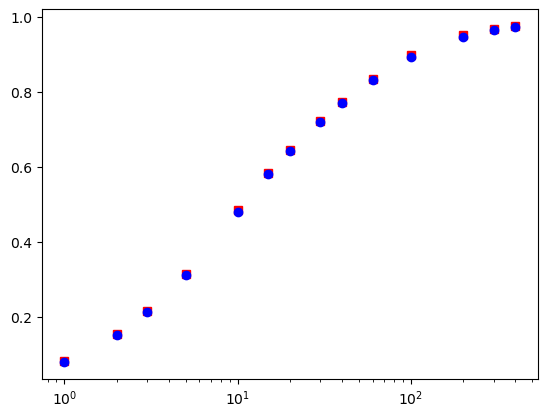

In [69]:
num_k = [1, 2, 3, 5, 10, 15, 20, 30, 40, 60, 100, 200, 300, 400]
recall_CTM = np.zeros((len(num_k),))
recall_SVD = np.zeros((len(num_k),))
for j, kk in enumerate(num_k):
    _, recalls = precision_recall_at_k(predictions_CTM, k=kk, threshold=2.5)
    recall_CTM[j] = sum(rec for rec in recalls.values()) / len(recalls)

    _, recalls = precision_recall_at_k(predictions_SVD, k=kk, threshold=2.5)
    recall_SVD[j] = sum(rec for rec in recalls.values()) / len(recalls)


fig, ax = plt.subplots(1, 1)

plt.semilogx(num_k, recall_SVD, 'rs')
plt.semilogx(num_k, recall_CTM, 'bo')

# Out of matrix predictions

In [10]:

# form dataset for CTM algorithmreader = Reader(rating_scale=(1.0, 5.0))
df_ratings_matrix = df_final[['userId', 'recsys_id', 'rating']]
df_ratings_matrix = df_ratings_matrix.iloc[0:1_000_000].copy()
df_ratings_matrix = df_ratings_matrix.reset_index(drop=True)

unique_movies = df_ratings_matrix['recsys_id'].unique()

train_num = int(0.80*len(unique_movies)) 
train_ids = np.random.choice(unique_movies, size=train_num, replace=False)
test_ids = np.setdiff1d(unique_movies, train_ids)


train_ilocs = [j for j in range(len(df_ratings_matrix)) if df_ratings_matrix.loc[j, 'recsys_id'] in train_ids]
test_ilocs = [j for j in range(len(df_ratings_matrix)) if df_ratings_matrix.loc[j, 'recsys_id'] in test_ids]

df_train = df_ratings_matrix.iloc[train_ilocs]
df_test = df_ratings_matrix.iloc[test_ilocs]


In [12]:
# randomize training set
reader= Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_train, reader)
trainset = data.build_full_trainset()
iids_in_train_set = [trainset.to_raw_iid(j) for j in range(trainset.n_items)]
theta = Xtran_main[iids_in_train_set, :]

# for val set for test
data_test = Dataset.load_from_df(df_test, reader)
_, testset = train_test_split(data_test, test_size=1.0)

In [14]:
algoCTM = CTM(theta=theta, n_epochs=40, reg_all=0.08)
algoCTM.fit(trainset)
 # return global mean of training set plus user-specific bias
print(f'CTM Test RMSE: {rmse(algoCTM.test(testset), verbose=False)}') 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [132]:
algoCTM.test(testset)

[Prediction(uid=56948, iid=29909, r_ui=4.5, est=3.4548348839891116, details={'was_impossible': False}),
 Prediction(uid=68010, iid=10109, r_ui=4.0, est=3.5385085024874092, details={'was_impossible': False}),
 Prediction(uid=39663, iid=30495, r_ui=3.5, est=3.839337104320622, details={'was_impossible': False}),
 Prediction(uid=8913, iid=25778, r_ui=4.0, est=3.8300046534319545, details={'was_impossible': False}),
 Prediction(uid=4507, iid=5926, r_ui=4.0, est=3.0719515077609136, details={'was_impossible': False}),
 Prediction(uid=60934, iid=6834, r_ui=2.0, est=3.5917086134869884, details={'was_impossible': False}),
 Prediction(uid=85804, iid=29878, r_ui=4.5, est=3.006285319005027, details={'was_impossible': False}),
 Prediction(uid=73177, iid=26118, r_ui=4.0, est=3.319023352470036, details={'was_impossible': False}),
 Prediction(uid=71277, iid=26681, r_ui=2.0, est=3.5062214074014784, details={'was_impossible': False}),
 Prediction(uid=16135, iid=25967, r_ui=3.0, est=3.8084200695829638, det

In [150]:
algoCTM.test_OOM(testset)

Prediction(uid=1, iid=32255, r_ui=3.5, est=3.606536926046042, details={'was_impossible': False})

In [155]:
algoCTM.trainset.global_mean + algoCTM.bu[55631]

3.4548348839891116

In [158]:
if True and False:
    print('Hello')